In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from scipy import io, sparse

from pathlib import Path

In [3]:
base_dir = Path().resolve()
parent_dir = base_dir.parent
parent_dir

PosixPath('/mnt/ldata/Sadegh/my_codes/spFlux')

# Read Converted R data and Make AnnData for All Tissue Micro Array

In [ ]:
data_dir = parent_dir / 'data/converted_files_to_python_readable'
data_dir

In [ ]:
adatas = []
keys = []
for subdir in sorted(data_dir.iterdir()):
    if subdir.is_dir():
        mtx_file = subdir / "counts.mtx"
        if not mtx_file.exists():
            print(f"Skipping {subdir}, counts.mtx not found")
            continue

        print(f"Reading {mtx_file}")
        # Read MTX and convert to CSR (cells x genes)
        X = io.mmread(mtx_file).T.tocsr()  

        # Read gene names
        genes_file = subdir / "genes.csv"
        var = None
        if genes_file.exists():
            var = pd.read_csv(genes_file)
            var = var.rename(columns={"x": "gene"})

        # Read cell metadata
        obs_file = subdir / "meta_data.csv"
        obs = None
        if obs_file.exists():
            obs = pd.read_csv(obs_file, index_col=0, low_memory=False)

        # Read spatial coords
        spatial = None
        cell_spatial_file = subdir / "spatial_coords.csv"
        if cell_spatial_file.exists():
            spatial = pd.read_csv(cell_spatial_file, index_col=0)
            spatial.index = spatial["cell"].astype(str) 
            spatial = spatial.drop(columns="cell")
            spatial = spatial.groupby("cell")[["x", "y"]].mean()

        # Create AnnData
        adata = sc.AnnData(X=X, obs=obs, var=var)
        if spatial is not None:
            adata.obsm["spatial"] = spatial.loc[adata.obs_names].values

        adatas.append(adata)
        keys.append(subdir.name)
        

In [ ]:
adatas

In [ ]:
all_TMA = sc.concat(adatas, keys=keys, label="sample", index_unique="_", join="outer", merge="first")
all_TMA

In [ ]:
print(f"Merged shape: {all_TMA.shape}")
all_TMA.write("merged_TMA.h5ad")

# Read all TMA dataset and Process it

In [ ]:
adata = sc.read(parent_dir / "data/h5ad/merged_TMA.h5ad")
adata

In [ ]:
# adata.var.to_csv('gene_name.csv', header=False, index=False)

In [ ]:
total_elements = adata.shape[0] * adata.shape[1] 
nonzero = adata.X.nnz                            
zero = total_elements - nonzero                  
sparsity = zero / total_elements * 100           

print(f"🔢 Total elements     : {total_elements:,}")
print(f"✅ Non-zero elements : {nonzero:,}")
print(f"⭕️ Zero elements     : {zero:,}")
print(f"📉 Sparsity          : {sparsity:.2f}% zeros")


### QC on anndata

In [ ]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

### Filtering on cells and genes

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4)

In [ ]:
print("Before filtering:", adata.shape)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print("After filtering:", adata.shape)

### Normalization and Logarithmic Data

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### Finding Highly Variable Genes

In [ ]:
# sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
# adata = adata[:, adata.var["highly_variable"]]
# adata

### Standardization data

In [ ]:
sc.pp.scale(adata, max_value=10)

### Apply PCA - Dimensional Reduction

In [ ]:
sc.tl.pca(adata, svd_solver="arpack")

### Neighborhood graph 

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

### Apply UMAP - Dimensional Reduction

In [ ]:
sc.tl.umap(adata)

### Clustering by Leiden method

In [ ]:
sc.tl.leiden(adata, resolution=0.5)

In [ ]:
adata

### Save Processed Dataset

In [ ]:
# adata.write(parent_dir / "merged_TMA_processed_compatible.h5ad", as_dense="X")

# Read Processed TMA dataset, Store as CSV and some Visualization

In [4]:
adata = sc.read(parent_dir / 'merged_TMA_processed_compatible.h5ad')

In [9]:
adata

AnnData object with n_obs × n_vars = 242061 × 1011
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'leiden'
    var: 'gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
counts_df = pd.DataFrame(
        adata.X,
        index=adata.obs_names,
        columns=adata.var.gene
    )
counts_df.T

,58_1_TMA1_minimal,63_1_TMA1_minimal,87_1_TMA1_minimal,191_1_TMA1_minimal,193_1_TMA1_minimal,202_1_TMA1_minimal,212_1_TMA1_minimal,236_1_TMA1_minimal,237_1_TMA1_minimal,262_1_TMA1_minimal,...,317_417_TMA4_minimal,335_417_TMA4_minimal,353_417_TMA4_minimal,368_417_TMA4_minimal,392_417_TMA4_minimal,398_417_TMA4_minimal,405_417_TMA4_minimal,411_417_TMA4_minimal,418_417_TMA4_minimal,586_417_TMA4_minimal
gene,,,,,,,,,,,,,,,,,,,,,
IER3,0.625482,1.293283,0.201813,1.080529,1.346717,0.843390,1.065943,1.283609,1.056173,0.963714,...,0.340534,-0.107207,0.839639,-1.656030,-1.656030,0.920197,0.885845,-0.089726,0.560347,0.250475
IFITM1,-2.756098,-0.206252,-0.088554,-0.601009,-0.416782,-0.263479,-0.924327,-0.679794,-0.288207,0.072642,...,-0.658736,-0.465181,-0.073521,-2.756098,0.211639,-1.085030,-1.038273,-2.756098,0.343155,-0.224332
TNFRSF10B,-0.651702,1.424346,1.341596,-0.651702,1.491918,-0.651702,1.433875,1.712290,-0.651702,-0.651702,...,-0.651702,-0.651702,-0.651702,-0.651702,1.666630,-0.651702,-0.651702,-0.651702,-0.651702,-0.651702
CEACAM1,-0.731706,1.022334,1.386837,-0.731706,-0.731706,-0.731706,1.030385,-0.731706,-0.731706,-0.731706,...,2.881940,2.523877,1.401000,1.197224,-0.731706,2.283548,2.065648,2.475531,2.459612,2.423657
CD58,-0.623874,-0.623874,1.363268,-0.623874,-0.623874,-0.623874,-0.623874,-0.623874,1.357450,-0.623874,...,1.249249,1.460062,1.379321,1.652119,-0.623874,-0.623874,-0.623874,1.483583,-0.623874,1.426236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Negative07,-0.252228,-0.252228,3.819182,-0.252228,4.126222,-0.252228,4.007666,-0.252228,-0.252228,4.173938,...,-0.252228,-0.252228,-0.252228,-0.252228,-0.252228,-0.252228,-0.252228,-0.252228,-0.252228,-0.252228
Negative08,-0.192518,-0.192518,-0.192518,-0.192518,-0.192518,-0.192518,-0.192518,-0.192518,-0.192518,-0.192518,...,-0.192518,-0.192518,-0.192518,-0.192518,-0.192518,-0.192518,-0.192518,-0.192518,-0.192518,-0.192518
Negative09,-0.248837,-0.248837,-0.248837,-0.248837,-0.248837,-0.248837,-0.248837,-0.248837,3.837001,-0.248837,...,-0.248837,-0.248837,-0.248837,-0.248837,-0.248837,-0.248837,-0.248837,-0.248837,-0.248837,-0.248837


In [ ]:
# counts_df.to_csv('merged_TMA_preprocessed.csv')

### PCA and UMAP

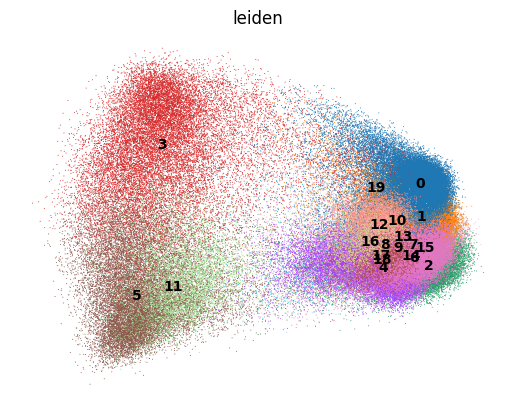

In [10]:
sc.pl.pca(
    adata,
    color=["leiden"],
    legend_loc="on data",
    frameon=False,
    size=2.0,
    wspace=0.3,
    save="_umap_leiden.png"  
)

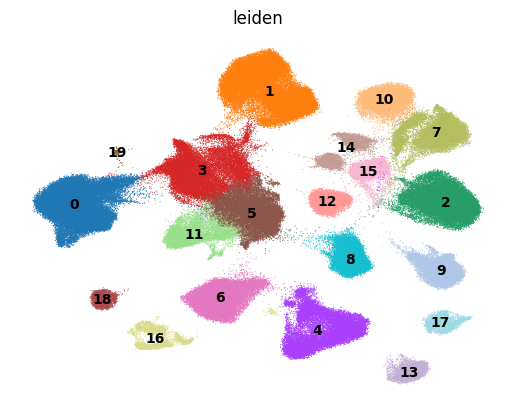

In [11]:
sc.pl.umap(
    adata,
    color=["leiden"],
    legend_loc="on data",
    frameon=False,
    size=2.0,
    wspace=0.3,
    save="_umap_leiden.png"  
)

### Plot Spatial coords based on leiden cluster

In [ ]:
# sc.pl.spatial(
#     adata,
#     color="leiden",
#     spot_size=100,     
#     frameon=False,
#     alpha_img=0.0,
#     save="_spatial_leiden.png" 
# )

### QC and Cell Compostion

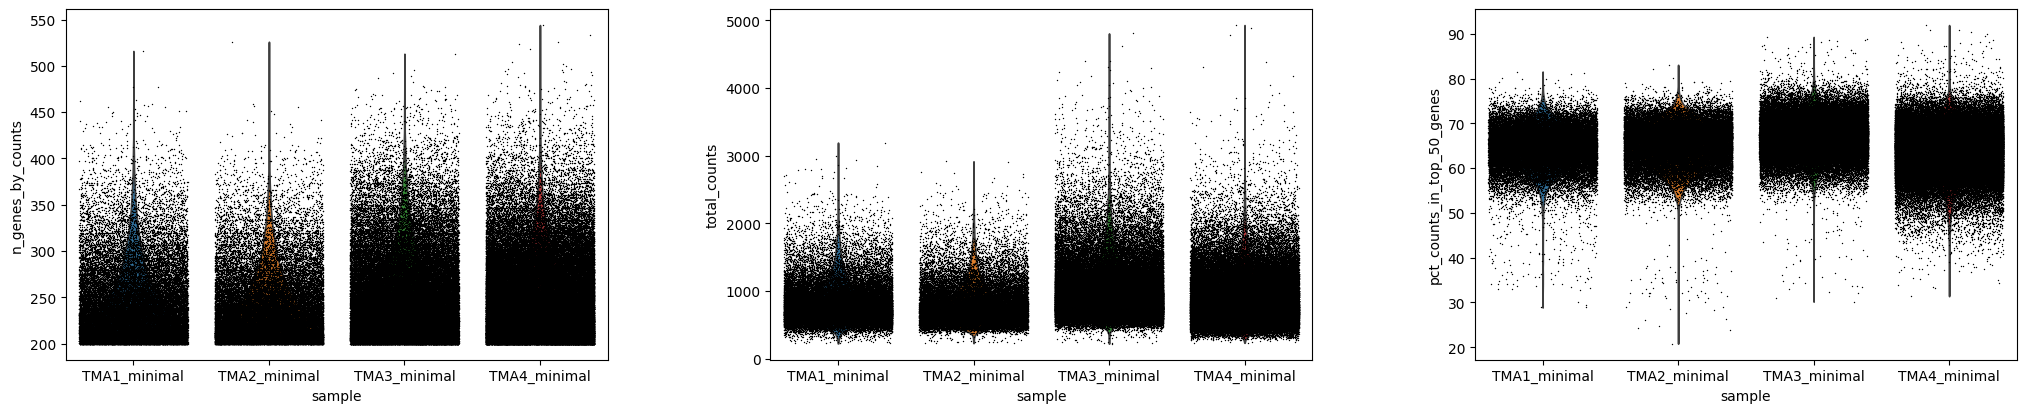

In [12]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_in_top_50_genes"],
    groupby="sample",
    jitter=0.4,
    multi_panel=True
)

<Axes: xlabel='leiden'>

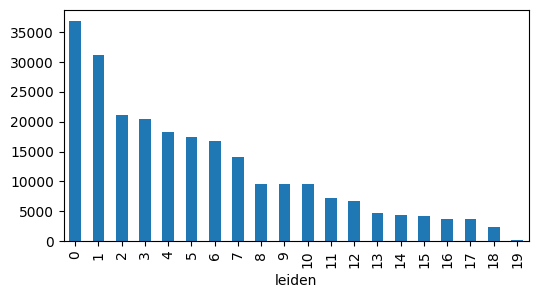

In [13]:
adata.obs["leiden"].value_counts().plot(kind="bar", figsize=(6,3))

### UMAP Visualization

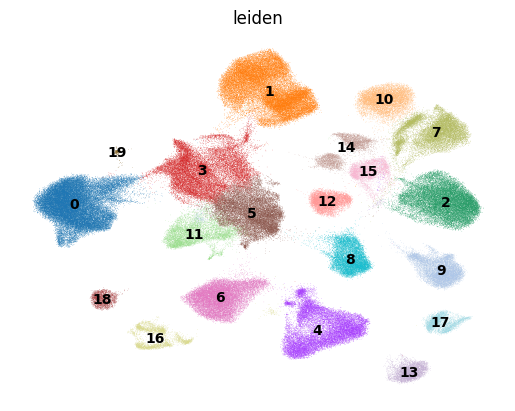

In [14]:
sc.pl.umap(adata, color="leiden", legend_loc="on data", frameon=False)

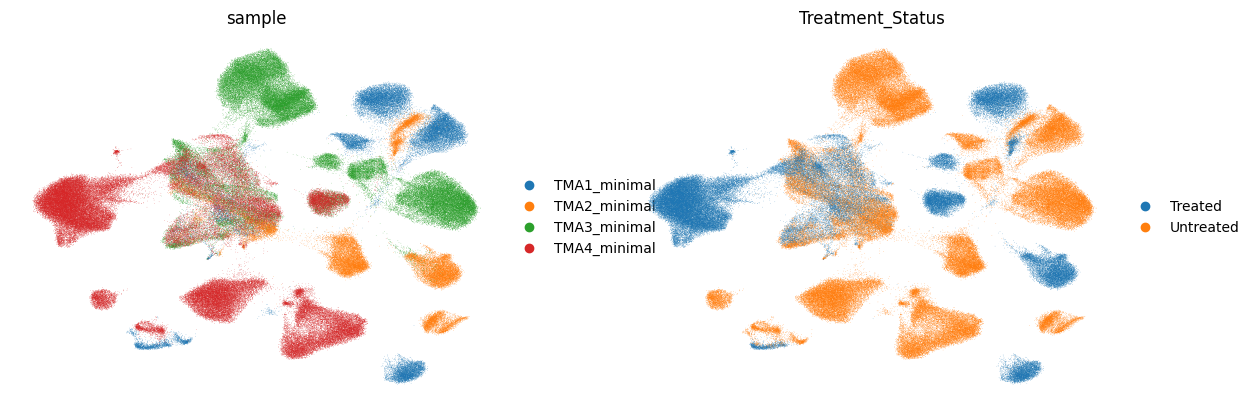

In [15]:
sc.pl.umap(adata, color=["sample", "Treatment_Status"], frameon=False)

### Spatial Visualization

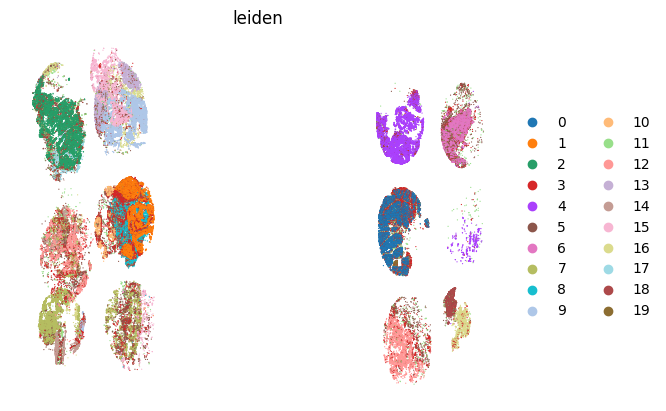

In [16]:
sc.pl.embedding(
    adata,
    basis="spatial",
    color="leiden",
    frameon=False,
    size=3
)


#### per Tissue Sample

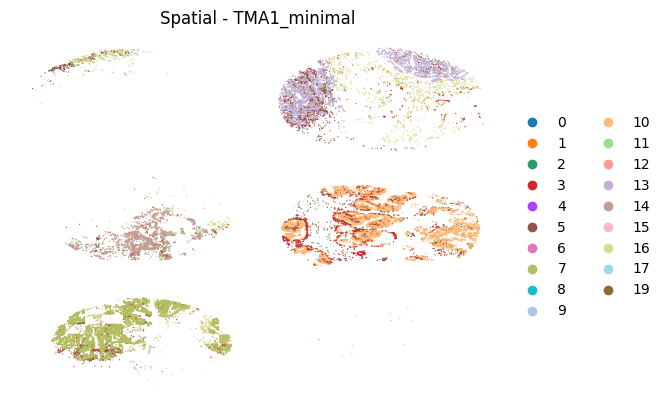

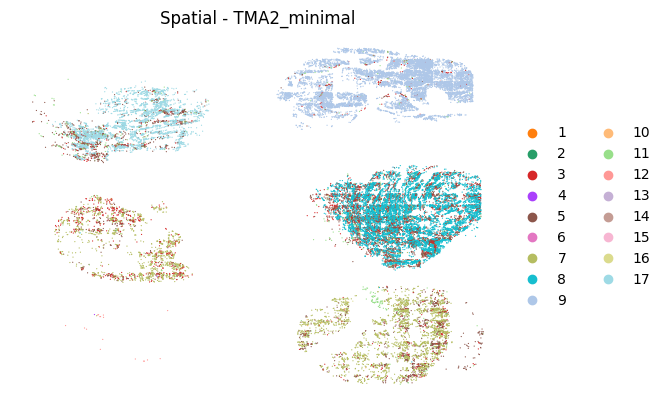

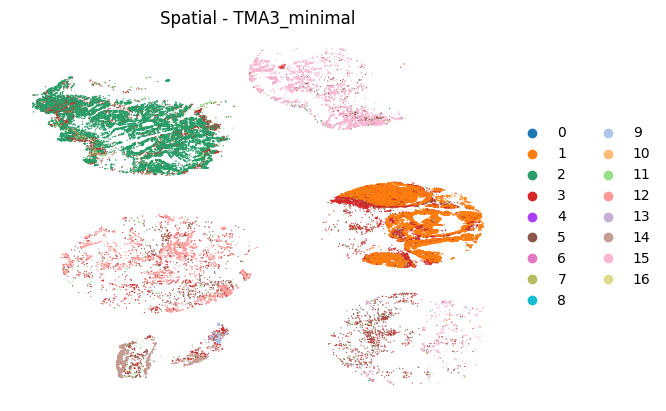

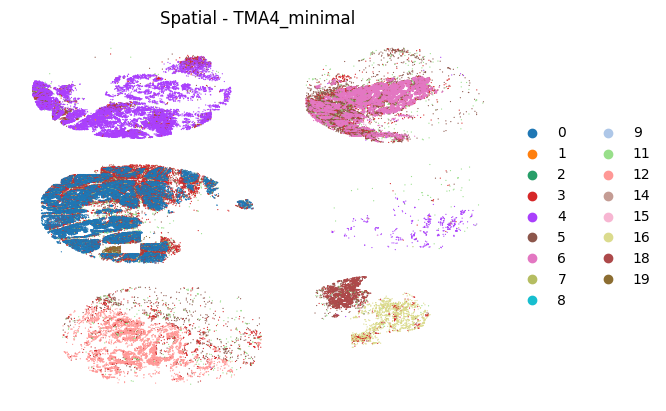

In [17]:
# Per Sample
for s in adata.obs["sample"].unique():
    sc.pl.embedding(
        adata[adata.obs["sample"] == s],
        basis="spatial",
        color="leiden",
        frameon=False,
        size=3,
        title=f"Spatial - {s}"
    )

### PCA Visualization

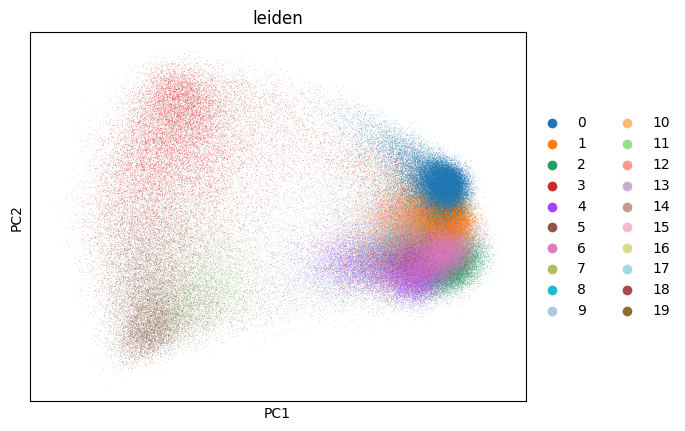

In [18]:
sc.pl.pca(adata, color="leiden")

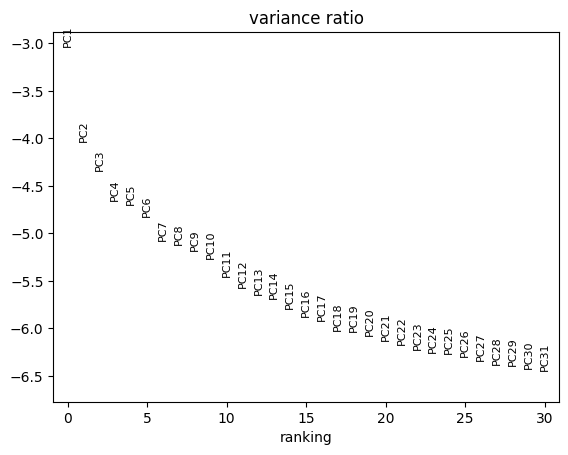

In [19]:
sc.pl.pca_variance_ratio(adata, log=True)

### Cluster Relationship 

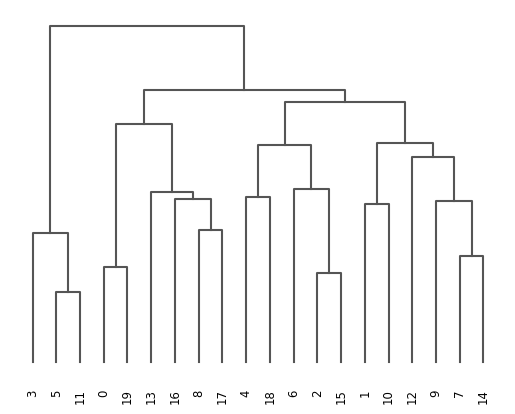

<Axes: >

In [20]:
sc.tl.dendrogram(adata, groupby="leiden")
sc.pl.dendrogram(adata, groupby="leiden")

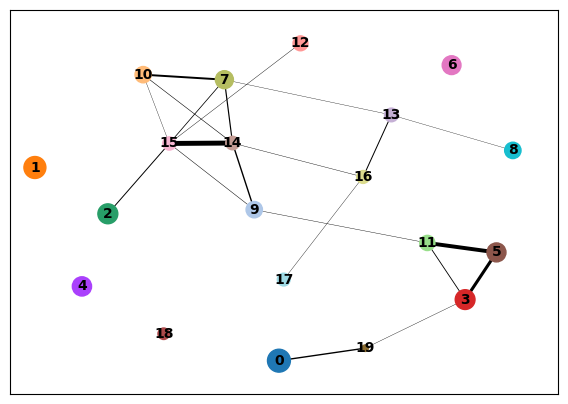

In [21]:
sc.tl.paga(adata, groups="leiden")
sc.pl.paga(adata, threshold=0.03, show=True)